<a href="https://colab.research.google.com/github/bhavangond/TensorFlow/blob/main/Transfer_Learning_in_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature extraction

## Downloading data

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()



--2025-08-18 04:17:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.188.207, 74.125.142.207, 74.125.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   110MB/s    in 1.5s    

2025-08-18 04:17:29 (110 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry

## Creating data loaders

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size=IMAGE_SHAPE,
                                           batch_size=BATCH_SIZE,
                                           class_mode="categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Callbacks

In [16]:
# TensorBoard callback
from keras.callbacks import TensorBoard
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to {log_dir}")
    return tensorboard_callback


## Creating models using Tensorflow Hub

In [5]:
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [17]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

def create_model(model_url, num_classes=10):
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False,
        name="feature_extraction_layer",
        input_shape=IMAGE_SHAPE + (3,)
    )

    model = tf_keras.Sequential([
        feature_extractor_layer,
        tf_keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

In [18]:
# Create Resnet Model

resnet_model=create_model(resnet_url,
                          )

In [19]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [20]:
# Compile model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf_keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [22]:
resnet_history=resnet_model.fit(train_data_10_percent,
                                epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                               )

Epoch 1/5
24/24 [==============================] - 18s 496ms/step - loss: 1.9898 - accuracy: 0.3333 - val_loss: 1.2018 - val_accuracy: 0.6292
Epoch 2/5
24/24 [==============================] - 12s 530ms/step - loss: 0.9473 - accuracy: 0.7213 - val_loss: 0.8465 - val_accuracy: 0.7348
Epoch 3/5
24/24 [==============================] - 12s 530ms/step - loss: 0.6372 - accuracy: 0.8027 - val_loss: 0.7523 - val_accuracy: 0.7592
Epoch 4/5
24/24 [==============================] - 12s 531ms/step - loss: 0.4620 - accuracy: 0.8933 - val_loss: 0.6944 - val_accuracy: 0.7792
Epoch 5/5
24/24 [==============================] - 10s 418ms/step - loss: 0.3802 - accuracy: 0.9120 - val_loss: 0.6761 - val_accuracy: 0.7816


In [23]:
# loss curve
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))


  # Plot loss
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accurcay
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


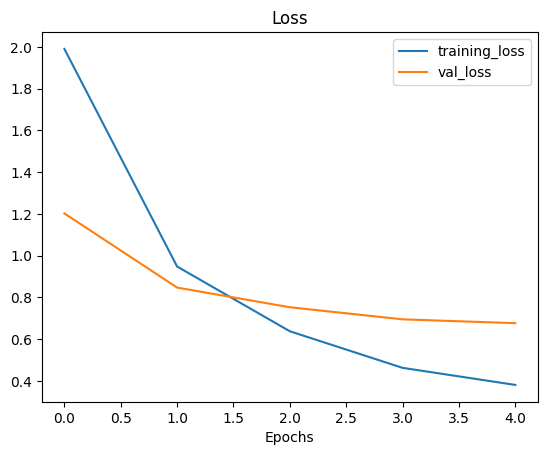

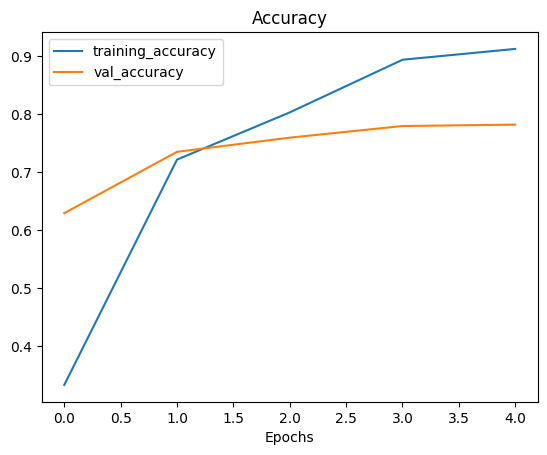

In [24]:
plot_loss_curves(resnet_history)

## efficientNet b0 model

In [27]:
# Create EfficientNet
efficientnet_model=create_model(model_url=efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

# Compile
efficientnet_model.compile(loss="categorical_crossentropy",
                   optimizer=tf_keras.optimizers.Adam(),
                   metrics=["accuracy"])

# Fit the model
efficientnet_history=efficientnet_model.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            )

Epoch 1/5
24/24 [==============================] - 26s 641ms/step - loss: 1.7775 - accuracy: 0.4907 - val_loss: 1.2705 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 12s 516ms/step - loss: 1.0254 - accuracy: 0.7960 - val_loss: 0.8424 - val_accuracy: 0.8316
Epoch 3/5
24/24 [==============================] - 9s 379ms/step - loss: 0.7524 - accuracy: 0.8453 - val_loss: 0.6764 - val_accuracy: 0.8560
Epoch 4/5
24/24 [==============================] - 9s 388ms/step - loss: 0.6193 - accuracy: 0.8547 - val_loss: 0.6043 - val_accuracy: 0.8524
Epoch 5/5
24/24 [==============================] - 12s 505ms/step - loss: 0.5036 - accuracy: 0.8960 - val_loss: 0.5453 - val_accuracy: 0.8692


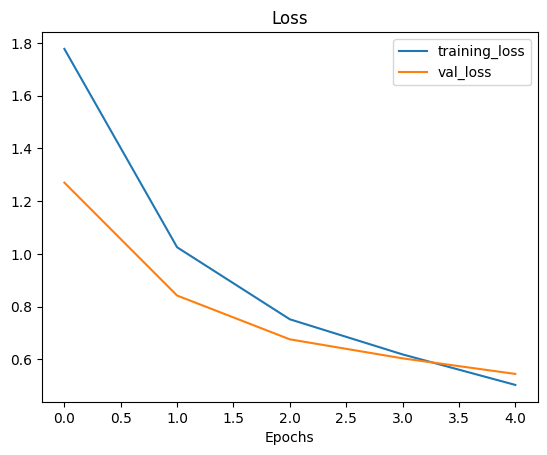

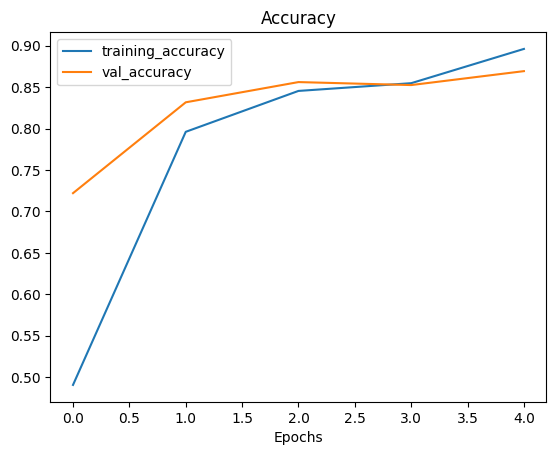

In [28]:
plot_loss_curves(efficientnet_history)

In [29]:
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________
